In [123]:
import nfl_data_py as nfl
import pandas as pd
import os
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg

In [142]:
import seaborn as sns
from matplotlib.patches import FancyArrowPatch

In [2]:
#clean 2024 data

df_twofour = nfl.import_pbp_data([2024], downcast=True, cache=False, alt_path=None, include_participation=False)

#regular season data only
df_twofour = df_twofour.loc[df_twofour.season_type=='REG']

#remove kick offs, field goals, kneels, etc - only plays with passes, runs, and penalties
df_twofour = df_twofour.loc[(df_twofour.play_type.isin(['no_play','pass','run'])) & (df_twofour.epa.isna()==False)]

#match play call to play type, so QB scrambles still considered pass plays
df_twofour.loc[df_twofour['pass']==1, 'play_type'] = 'pass'
df_twofour.loc[df_twofour.rush==1, 'play_type'] = 'run'

#reset index to skip missing numbers
df_twofour.reset_index(drop=True, inplace=True)

df_twofour.head()

2024 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,61.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.200602,NaN,NaN,NaN,NaN,NaN,0.456761,-45.676102
1,83.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,2.028874,1.345418,9.321221,8.0,0.509778,0.363807,0.576656,42.334431
2,108.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,0.754242,0.882798,5.783560,4.0,0.668478,0.255140,0.426443,57.355690
3,133.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.029602,NaN,NaN,NaN,NaN,NaN,0.225364,-22.536427
4,155.0,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,...,0.0,0.0,-0.247749,NaN,NaN,NaN,NaN,NaN,0.424099,-42.409935


In [109]:
qbs_oneh = (
    df_twofour.loc[
        (df_twofour['week'].between(1, 6)) & (df_twofour['play_type'] == 'pass')
    ]
    .groupby(['passer', 'posteam'], as_index=False)
    .agg({
        'qb_epa': 'mean',  # Mean QB EPA per group
        'cpoe': 'mean',    # Mean Completion Percentage Over Expected per group
        'play_id': 'count' # Count of plays per group
    })
)

qbs_oneh=qbs_oneh.loc[qbs_oneh.play_id>100]

#Sort in descending order by EPA 
qbs_oneh.sort_values('qb_epa', ascending=False, inplace=True)

#Round to two decimal places where appropriate
qbs_oneh = qbs_oneh.round(2)



qbs_oneh.rename(
    columns={
        'passer': 'Player',
        'posteam': 'Team',
        'qb_epa': '1H EPA',
        'cpoe': '1H CPOE',
        'play_id': 'Dropbacks'
              
        
    },
    inplace=True
)

qbs_oneh['Rank'] = range(1, len(qbs_oneh) + 1)


qbs_oneh = qbs_oneh[['Rank', 'Player', 'Team', '1H EPA', '1H CPOE', 'Dropbacks']]

qbs_oneh

#if you want to pass styler object with the index hidden - not this creates a styler object which cannot be merged:

#qbs_twoh_style = qbs_twoh.style.format({'2H EPA': '{:.2f}', '2H CPOE': '{:.2f}'}).hide(axis="index")

#qbs_twoh_style
#qbs_oneh_styler = qbs_oneh.style.format({'1H EPA': '{:.2f}', '1H CPOE': '{:.2f}'}).hide(axis="index")

#qbs_oneh_styler

,Rank,Player,Team,1H EPA,1H CPOE,Dropbacks
26,1,J.Daniels,WAS,0.36,8.13,224
23,2,J.Allen,BUF,0.28,2.42,199
25,3,J.Burrow,CIN,0.26,6.94,239
28,4,J.Flacco,IND,0.25,3.31,124
41,5,L.Jackson,BAL,0.25,2.60,215
7,6,B.Purdy,SF,0.22,3.35,226
5,7,B.Mayfield,TB,0.17,-0.08,232
51,8,S.Darnold,MIN,0.16,3.80,171
39,9,K.Cousins,ATL,0.16,1.91,237
40,10,K.Murray,ARI,0.16,1.52,207


In [110]:
#second half


qbs_twoh = (
    df_twofour.loc[
        (df_twofour['week'].between(7, 11)) & (df_twofour['play_type'] == 'pass')
    ]
    .groupby(['passer', 'posteam'], as_index=False)
    .agg({
        'qb_epa': 'mean',  # Mean QB EPA per group
        'cpoe': 'mean',    # Mean Completion Percentage Over Expected per group
        'play_id': 'count' # Count of plays per group
    })
)

qbs_twoh=qbs_twoh.loc[qbs_twoh.play_id>100]

#Sort in descending order by EPA 
qbs_twoh.sort_values('qb_epa', ascending=False, inplace=True)


#Round to two decimal places where appropriate
qbs_twoh = qbs_twoh.round(2)



qbs_twoh.rename(
    columns={
        'passer': 'Player',
        'posteam': 'Team',
        'qb_epa': '2H EPA',
        'cpoe': '2H CPOE',
        'play_id': 'Dropbacks'
              
        
    },
    inplace=True
)

qbs_twoh['Rank'] = range(1, len(qbs_twoh) + 1)


qbs_twoh = qbs_twoh[['Rank', 'Player', 'Team', '2H EPA', '2H CPOE', 'Dropbacks']]

qbs_twoh

#if you want to pass styler object with the index hidden - not this creates a styler object which cannot be merged:

#qbs_twoh_style = qbs_twoh.style.format({'2H EPA': '{:.2f}', '2H CPOE': '{:.2f}'}).hide(axis="index")

#qbs_twoh_style


,Rank,Player,Team,2H EPA,2H CPOE,Dropbacks
44,1,L.Jackson,BAL,0.43,6.22,177
31,2,J.Goff,DET,0.39,12.18,139
62,3,T.Tagovailoa,MIA,0.39,7.83,143
42,4,K.Murray,ARI,0.36,3.87,120
26,5,J.Allen,BUF,0.23,0.57,213
35,6,J.Hurts,PHI,0.20,12.28,146
28,7,J.Burrow,CIN,0.20,1.72,237
52,8,P.Mahomes,KC,0.19,6.17,216
8,9,B.Purdy,SF,0.18,1.09,158
50,10,M.Stafford,LA,0.18,0.76,190


In [121]:
#this section starts the graphics display

#first up is merging data

#updating above dfs to only show the columns I want
qbs_one = qbs_oneh[['Player', 'Team', '1H EPA', '1H CPOE']]
qbs_two = qbs_twoh[['Player', 'Team', '2H EPA', '2H CPOE']]


merged_qb = pd.merge(
    qbs_one, 
    qbs_two, 
    on=['Player', 'Team'],  # Replace with the actual column names to join on
    #suffixes=('_oneh', '_twoh')  # Optional: differentiate column names
).reset_index(drop=True)

merged_qb


,Player,Team,1H EPA,1H CPOE,2H EPA,2H CPOE
0,J.Daniels,WAS,0.36,8.13,0.14,-2.51
1,J.Allen,BUF,0.28,2.42,0.23,0.57
2,J.Burrow,CIN,0.26,6.94,0.20,1.72
3,L.Jackson,BAL,0.25,2.60,0.43,6.22
4,B.Purdy,SF,0.22,3.35,0.18,1.09
5,B.Mayfield,TB,0.17,-0.08,0.13,3.60
6,S.Darnold,MIN,0.16,3.80,0.09,9.55
7,K.Cousins,ATL,0.16,1.91,0.07,3.72
8,K.Murray,ARI,0.16,1.52,0.36,3.87
9,J.Love,GB,0.15,-4.01,0.15,4.42


In [126]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

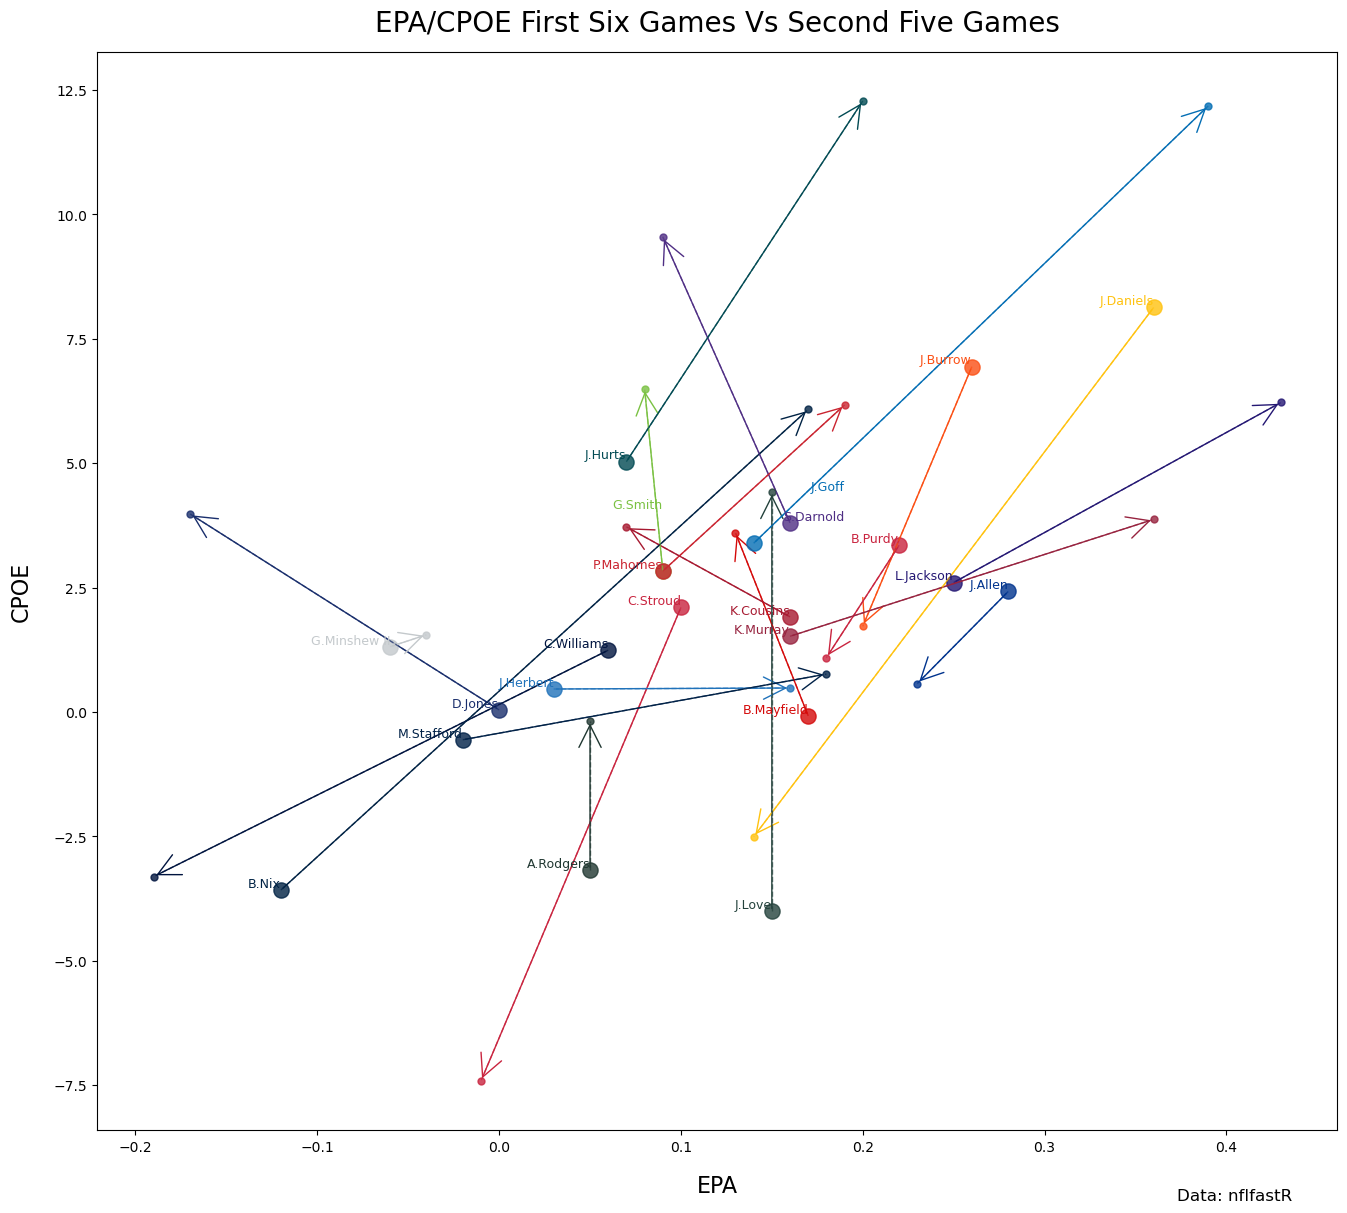

In [169]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 14))  # Adjust size to zoom in/out

# Map colors based on the team
merged_qb['color'] = merged_qb['Team'].map(COLORS)

# Define custom label offsets for specific players
label_offsets = {
    'G.Smith': (0.0, 1.2),    
    'J.Goff': (0.05, 1.0),
    'S.Darnold': (.03, 0.0),
}

# Plot dots for "1H EPA"/"1H CPOE" and "2H EPA"/"2H CPOE"
for _, row in merged_qb.iterrows():
    
    # Plot the "1H" point (regular size)
    ax.scatter(row['1H EPA'], row['1H CPOE'], color=row['color'], s=120, label=row['Player'], alpha=0.8)
    
    # Plot the "2H" point (smaller size)
    ax.scatter(row['2H EPA'], row['2H CPOE'], color=row['color'], s=25, alpha=0.8)
    
    # Draw a dashed line between the points
    ax.plot(
        [row['1H EPA'], row['2H EPA']],
        [row['1H CPOE'], row['2H CPOE']],
        color=row['color'],
        linestyle='--',
        linewidth=1,
        alpha=0.7,
    )
    
    # Add arrow to show direction (larger arrowhead)
    arrow = FancyArrowPatch(
        (row['1H EPA'], row['1H CPOE']),  # Start point
        (row['2H EPA'], row['2H CPOE']),  # End point
        arrowstyle='->',
        color=row['color'],
        mutation_scale=40  # Larger arrowhead
    )
    ax.add_patch(arrow)

    # Determine label offsets for the player
    x_offset, y_offset = label_offsets.get(row['Player'], (0, 0))

    # Add player name as a label to the "1H" point
    ax.text(
        row['1H EPA'] + x_offset,
        row['1H CPOE'] + y_offset, 
        row['Player'], 
        fontsize=9, 
        color=row['color'], 
        ha='right', 
        va='bottom'
    )

# Customize the plot
ax.set_title('EPA/CPOE First Six Games Vs Second Five Games', fontsize=20, pad=15)
ax.set_xlabel('EPA', fontsize=16, labelpad=15)
ax.set_ylabel('CPOE', fontsize=16, labelpad=15)
plt.figtext(.8, .06, 'Data: nflfastR', fontsize=12)

# Hide the legend entirely
ax.legend().remove()

#save figure
plt.savefig('qb_epa_cpoe.png',dpi=300)

# Show the plot
plt.show()

